# COMP24111 - Exercise 3: _Face recognition_

## 1. Task description

You will work on a face recognition task. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [1]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np

Now you can load the data:

In [2]:
data, labels = load_data()

### Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

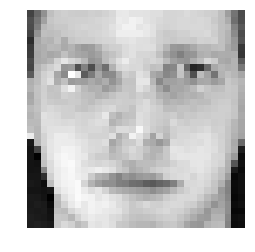

In [3]:
# Display a single example.
show_single_face(data[0, :])

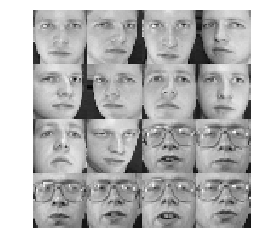

In [4]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### Splitting into train and test set

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. It takes the labels and the specified number $N$ as the input. It returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [5]:
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares implementation

Now, you will need to implement the function `l2_rls_train` below. It should train a linear model by minimising the $L_2$-regularised sum of squares loss using the normal equations (this is called $L_2$*-regularised least squares model*, or *ridge regression model*). It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights.

In [411]:
def l2_rls_train(tr_data, tr_labels, givenL
                ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = tr_data, tr_labels
    
    # Expand X with a column of ones.
    toAppend = np.ones((np.shape(X)[0], 1), dtype=int)
    X_tilde = np.concatenate((toAppend, X), axis=1)
    
    # Compute the coefficient vector.
    lambdaI = np.identity(np.shape(X_tilde)[1]) * givenL
    if(givenL == 0):
        w = np.linalg.pinv(X_tilde) @ y
    elif(givenL > 0):
        w = (np.linalg.inv(((X_tilde.T) @ X_tilde) + lambdaI) @ (X_tilde.T)) @ y
    else:
        print("lambda must be greater than or equal to 0")
    #Return model parameters.
    return w

Once you have trained your model, you can use it on to predict new data. Implement the following function to do this.

In [403]:
def l2_rls_predict(w, data, # Add any other arguments here
                  ):
    """
    A summary of your function goes here.

    data: type and description of "data"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X = data
    toAppend = np.ones((np.shape(X)[0], 1), dtype=int)
    X_tilde = np.concatenate((toAppend, X), axis=1).astype(np.float64)
    # Your code goes here
    predicted_y = X_tilde @ w
    return predicted_y

## 4. Experiments

Start to use your functions `l2_rls_train` and `l2_rls_predict` to perform the following experiments.

### Experiment 1: Binary Classification

Start with a binary classification task to classify face images for subjects “1” and “30”.

Train three classifiers:
1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” to train a linear model, and use the threshold $T= 0$ to obtain the class prediction.
2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” to train a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
2. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” to train a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [404]:
def exp1(label_class_1, label_class_30):
    # Map the labels and partition the data
    trainErr, testErr = np.zeros(50), np.zeros(50)
    labels_1_30 = np.append(labels[:10], labels[290:300])
    wrong1, wrong30 = 0, 0
    for p in range(50):
        tr_ind, te_ind = partition_data(labels_1_30, num_per_class=3)
        for i in range(3, 6):
            tr_ind[i] += 280
        for i in range(7, 14):
            te_ind[i] += 280
        tr_data = data[tr_ind, :]
        tr_label = [label_class_1, label_class_1, label_class_1, label_class_30, label_class_30, label_class_30]
        te_data = data[te_ind, :]
        # Train your model
        w = l2_rls_train(tr_data, tr_label, 0)
    
        # Define the threshold
        T = (label_class_1 + label_class_30)/2
        
        # Perform prediction for training and compute the training error
        predictedYTrain = l2_rls_predict(w, tr_data)
        trainErrCount = 0
        for i in range(3):
            if(predictedYTrain[i] > T ):
                trainErrCount += 1
        for i in range(3, 6):
            if(predictedYTrain[i] <= T):
                trainErrCount += 1
        errorRateTr = trainErrCount / 6
        trainErr[p] = errorRateTr
        
        # Perform prediction for testing and compute the test error
        predictedYTest = l2_rls_predict(w, te_data)
        testErrCount = 0
        for i in range(7):
            if(predictedYTest[i] > T ):
                testErrCount += 1

        for i in range(7, 14):
            if(predictedYTest[i] <= T):
                testErrCount += 1

        errorRateTe = testErrCount / 14
        testErr[p] = errorRateTe
        
    trainErrMean = np.mean(trainErr)
    testErrMean = np.mean(testErr)
    trainSTD = np.std(trainErr)
    testSTD = np.std(testErr)
    
    return trainErrMean, testErrMean, trainSTD, testSTD

In [405]:
# Use the `exp1()` function to experiment with classifier 1.
# Your code goes here.
class1_label = -1
class30_label = 1

#T = 0
tr_errMean_c1, te_errMean_c1, tr_errSTD_c1, te_errSTD_c1 = exp1(class1_label, class30_label)

print("The training error Mean is: ", tr_errMean_c1)
print("The testing error Mean is: ", te_errMean_c1)
print("The training Standard Deviation is ", tr_errSTD_c1)
print("The testing Standard Deviation is ", te_errSTD_c1)


The training error Mean is:  0.0
The testing error Mean is:  0.06857142857142856
The training Standard Deviation is  0.0
The testing Standard Deviation is  0.07948815853282032


Repeat the same experiment for classifier 2.

In [406]:
# Use the `exp1()` function to experiment with classifier 2.
# Your code goes here.
class1_label = 0
class30_label = 1

#T = 0
tr_errMean_c2, te_errMean_c2, tr_errSTD_c2, te_errSTD_c2 = exp1(class1_label, class30_label)

print("The training error Mean is: ", tr_errMean_c2)
print("The testing error Mean is: ", te_errMean_c2)
print("The training Standard Deviation is ", tr_errSTD_c2)
print("The testing Standard Deviation is ", te_errSTD_c2)


The training error Mean is:  0.0
The testing error Mean is:  0.0757142857142857
The training Standard Deviation is  0.0
The testing Standard Deviation is  0.09732126474429198


Repeat the same experiment for classifier 3.

In [407]:
# Use the `exp1()` function to experiment with classifier 3.
# Your code goes here.
class1_label = 1
class30_label = 30

#T = 0
tr_errMean_c3, te_errMean_c3, tr_errSTD_c3, te_errSTD_c3 = exp1(class1_label, class30_label)

print("The training error Mean is: ", tr_errMean_c3)
print("The testing error Mean is: ", te_errMean_c3)
print("The training Standard Deviation is ", tr_errSTD_c3)
print("The testing Standard Deviation is ", te_errSTD_c3)



The training error Mean is:  0.0
The testing error Mean is:  0.08142857142857142
The training Standard Deviation is  0.0
The testing Standard Deviation is  0.0903620834335341


Print the test error mean and standard deviation of the three classifiers and display them in the same plot.

The mean Error of classifier 1 is  0.06857142857142856 	Standard Deviation is:  0.07948815853282032
The mean Error of classifier 2 is  0.0757142857142857 	Standard Deviation is:  0.09732126474429198
The mean Error of classifier 3 is  0.08142857142857142 	Standard Deviation is:  0.0903620834335341


<function matplotlib.pyplot.show(*args, **kw)>

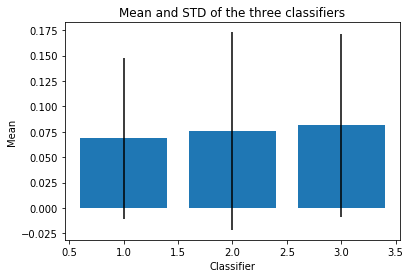

In [408]:
# Your code goes here
from matplotlib import pyplot as plt
print("The mean Error of classifier 1 is ", te_errMean_c1, "\tStandard Deviation is: ", te_errSTD_c1)
print("The mean Error of classifier 2 is ", te_errMean_c2, "\tStandard Deviation is: ", te_errSTD_c2)
print("The mean Error of classifier 3 is ", te_errMean_c3, "\tStandard Deviation is: ", te_errSTD_c3)
plt.bar([1, 2, 3], [te_errMean_c1, te_errMean_c2, te_errMean_c3], yerr=[te_errSTD_c1, te_errSTD_c2, te_errSTD_c3])
plt.title("Mean and STD of the three classifiers")
plt.ylabel("Mean")
plt.xlabel("Classifier")
plt.show

Compare the three classifiers and comment on your results.

What training accuracies do you obtain with your linear classifier? Explain the reason.

Between subjects “1” and “30”, which one is more difficult for the linear classifier to recognise? Explain it.

### Experiment 2: Multi-class Classification

Now, proceed to the multi-class classification task to classify face images for all the 40 subjects. Decide an appropriate way to set your target output and make class prediction. 

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. 

Write your code below and make sure it compiles. Show your code to the TA, explain your classifier and experiment design.

In [420]:
def hyperparameter_selection(givenData, givenLabels
                            ):
    """
    Finds the best value for lambda using some method of hyperparameter selection.
    """
    #parition the data again into training and testing
    tr_ind, te_ind = partition_data(givenLabels, num_per_class=2)
    tr_data = givenData[tr_ind, :]
    tr_label = np.zeros((80,40))
    for i in range(40):
        for j in range(2*i, 2*(i+1)):
            tr_label[j][i] =1
    
    te_label = givenLabels[te_ind]
    te_data = givenData[te_ind, :]
    
    best_lambda = 0
    highestCount = 0
    for i in range(30):
        currentLambda = 10**((-5)+(i/2))
        w = l2_rls_train(tr_data, tr_label, currentLambda)
        predictedY = l2_rls_predict(w, te_data)
        predictedClass = np.argmax(predictedY, axis=1) +1
        currentCount = 0
        for i in range(120):
            if (predictedClass[i] == te_label[i]):
                currentCount += 1
                
        if currentCount > highestCount:
            best_lambda = currentLambda
            highestCount = currentCount
            print("Best lambda so far: ", best_lambda)
    return best_lambda

In [422]:
tr_ind, te_ind = partition_data(labels, num_per_class=5)
tr_data = data[tr_ind, :]
tr_label = np.zeros((200,40))
trainingLabelsSingle = labels[tr_ind]
te_label = labels[te_ind]
for i in range(40):
    for j in range(5*i, 5*(i+1)):
        tr_label[j][i] =1
        
te_data = data[te_ind, :]

best_lambda = hyperparameter_selection(tr_data, trainingLabelsSingle)

# Train your model
w = l2_rls_train(tr_data, tr_label, best_lambda)    
     
# Perform prediction for training and compute the training error
predictedYTrain = l2_rls_predict(w, tr_data)

predictedTrClass = np.argmax(predictedYTrain, axis=1) +1

predictedYTest = l2_rls_predict(w, te_data)

predictedTeClass = np.argmax(predictedYTest, axis=1) +1

correctCountTrain = 0
for i in range(200):
    if (predictedTrClass[i] == trainingLabelsSingle[i]):
        correctCountTrain += 1
correctCountTrain /= 2

correctCountTest = 0
for i in range(200):
    if (predictedTeClass[i] == te_label[i]):
        correctCountTest += 1
correctCountTest /= 2

print("Best Lambda = ", best_lambda)
print("Training correctness = ", correctCountTrain, "%")
print("Testing correctness = ", correctCountTest, "%")
print(predictedTeClass)


Best lambda so far:  1e-05
Best lambda so far:  10000.0
Best lambda so far:  31622.776601683792
Best lambda so far:  100000.0
Best Lambda =  100000.0
Training correctness =  100.0 %
Testing correctness =  94.0 %
[ 1  6 40 16  1  2  2  2  2  2  3  3  3 10 10  4  4  4  4  4  5  5  5  5
  5  6 31  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9  9  9 10 10 10
 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14 14 14 14 15 15
 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19 19 19 19 19 20
 20 20 20 20 21  3 21 21 21 22 22 22 39 22 23 23 23 23 23 24 24 24 24 24
 25 25 25 25 25 26 26  3 26 26 27 27 27 27 27 28 28 28 28 13 29 29 29 29
 29 30 30 30 30 30 31 31 31 31 31 32 32 32 32 32 33 33 33 33 33 34 34 34
 34 34 35 35 35 35  5 36 36 36 36 30 37 37 37 37 37 38 38 38 38 38 39 39
 39 39 39 40 40 40 40 40]


Analyse the classification results, and pick some subjects that are considered the most difficult to recognise by your classifier. Show and explain it to the TA.

### Experiment 3: Face Completion

Revise the “Regression Example II” on face completion in Chapter 2. The task is to guess the 512 pixels of the right face from the 512 pixels of the left face. 

The following command can be used to extract the left and right faces from the input data.

In [273]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

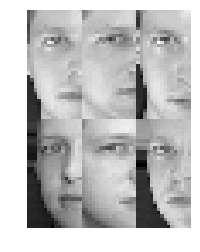

In [274]:
show_split_faces(left[:6, :], num_per_row=3)

Build a face completion model using your functions `l2_rls_train` and `l2_rls_predict`. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles. Show your code to the TA, explain your model and experiment design, and demonstrate results.

In [300]:
tr_ind, te_ind = partition_data(labels, num_per_class=5)
tr_data_left = left[tr_ind, :]
tr_data_right = right[tr_ind, :]

te_data_left = left[te_ind, :]
te_data_right = right[te_ind, :]

w = l2_rls_train(tr_data_left, tr_data_right, 0)

te_data_right_predicted = l2_rls_predict(w, te_data_left)

meanAbsolutePercentageError = np.mean(np.abs((te_data_right - te_data_right_predicted) / te_data_right))
print("The mean Absolute Percentage Error is ", meanAbsolutePercentageError)

The mean Absolute Percentage Error is  0.22229121607206279


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

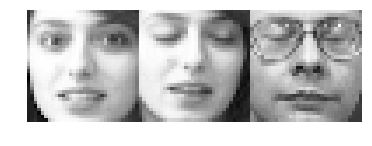

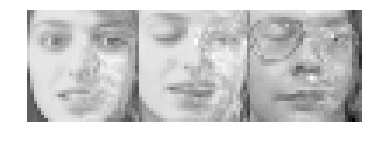

In [294]:
#choose 3 random faces
randomChoices = np.random.choice(range(40), size=3, replace=False)
#true faces
show_faces(join_left_right(te_data_left[randomChoices], te_data_right[randomChoices]), num_per_row=3)
show_faces(join_left_right(te_data_left[randomChoices], te_data_right_predicted[randomChoices]), num_per_row=3)


Does your model work well? Comment on it.

## 5. Deliverables and Marking

By the deadline, you should submit one single Jupyter file using GitLab. Please find the coursework submission instruction from the following link: https://wiki.cs.manchester.ac.uk/index.php/UGHandbook19:Coursework .

This exercise is worth 15 marks – marks will be allocated roughly on the basis of: 
- rigorous experimentation,
- knowledge displayed when talking to the TA,
- problem solving skill,
- self-learning ability,
- how informative and well presented your graphs are,
- language and ease of reading.

You must be able to explain any code you've written in order to get full marks. During the marking session we will ask you to run all cells in your Jupyter file, so ensure that the file is runnable using the "Restart Kernel and Run All Cells" menu option.

The lab is marked out of 15:

|                          |         |
|:------------------------ |--------:|
| $L_2$-RLS Implementation | 3 marks |
| Experiment 1             | 4 marks |
| Experiment 2             | 4 marks |
| Experiment 3             | 4 marks |